In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pysgpp import RegressionLearner, RegularGridConfiguration, \
AdpativityConfiguration, SLESolverConfiguration, RegularizationConfiguration, DataMatrix, \
DataVector
import numpy as np
import sklearn.preprocessing as pre
import sklearn.base
import sklearn.datasets
import sklearn.grid_search
from sklearn.cross_validation import ShuffleSplit

sns.set_style("darkgrid")
sns.set_palette("muted")

In [2]:
(X,Y) = sklearn.datasets.make_friedman3(n_samples=500,noise=1.0, random_state=42)

In [3]:
scaler = pre.MinMaxScaler()
X = scaler.fit_transform(X)

In [4]:
def to_data_matrix(arr):
    (size_x, size_y) = arr.shape
    matrix = DataMatrix(size_x, size_y)
    cur_row = 0
    for x in arr:
        x_vec = DataVector(x.tolist())
        matrix.setRow(cur_row,x_vec)
        cur_row += 1
    return matrix      
        
# http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator
class SGRegressionLearner(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin):
    def __init__(self, lambdaReg=0.01, typeReg=2):
        self.lambdaReg = lambdaReg      
        self.typeReg = typeReg
            
    def fit(self, X, y):        
        grid_config = RegularGridConfiguration()
        grid_config.dim_ = X.shape[1]
        grid_config.level_ = 2
        grid_config.type_ = 6 #ModLinear
        grid_config.t_ = 0.5

        adaptivity_config = AdpativityConfiguration()
        adaptivity_config.noPoints_ = 0
        adaptivity_config.numRefinements_ = 0

        solver_config = SLESolverConfiguration()
        solver_config.type_ = 0 # CG
        solver_config.maxIterations_ = 500
        solver_config.eps_ = 1e-6

        regularization_config = RegularizationConfiguration()
        regularization_config.exponentBase_ = 0.25
        regularization_config.regType_ = self.typeReg # diagonal = 2
        regularization_config.lambda_ = self.lambdaReg
        self._learner = RegressionLearner(grid_config, adaptivity_config, solver_config, regularization_config)
                
        X_mat = to_data_matrix(X)
        y_vec = DataVector(y.tolist())
        self._learner.train(X_mat, y_vec)
            
    def predict(self, X):
        X_mat = to_data_matrix(X)
        result = self._learner.predict(X_mat)
        return result.array()
    
    def score(self, X, y, sample_weight=None):
        X_mat = to_data_matrix(X)
        y_vec = DataVector(y.tolist())
        mse = self._learner.getMSE(X_mat, y_vec)
        return -mse

In [5]:
learner = SGRegressionLearner()
cv = ShuffleSplit(X.shape[0], random_state=42)
lambdaGrid = np.logspace(1, -4, num=50)
parameters = [{"lambdaReg": lambdaGrid, "typeReg": [2]}, # diag
              {"lambdaReg": lambdaGrid, "typeReg": [0]}] # ident
gridSearch = sklearn.grid_search.GridSearchCV(learner, parameters, cv=cv, verbose=1, n_jobs=4)

In [6]:
gridSearch.fit(X,Y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 450 jobs       | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 800 jobs       | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 994 out of 1000 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    4.7s finished


GridSearchCV(cv=ShuffleSplit(500, n_iter=10, test_size=0.1, random_state=42),
       error_score='raise',
       estimator=SGRegressionLearner(lambdaReg=0.01, typeReg=2),
       fit_params={}, iid=True, loss_func=None, n_jobs=4,
       param_grid=[{'typeReg': [2], 'lambdaReg': array([  1.00000e+01,   7.90604e+00,   6.25055e+00,   4.94171e+00,
         3.90694e+00,   3.08884e+00,   2.44205e+00,   1.93070e+00,
         1.52642e+00,   1.20679e+00,   9.54095e-01,   7.54312e-01,
         5.96362e-01,   4.71487e-01,   3.72759e-01,   2.9...   3.23746e-04,   2.55955e-04,   2.02359e-04,   1.59986e-04,
         1.26486e-04,   1.00000e-04])}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

In [7]:
scores = gridSearch.grid_scores_
diag_scores = [s for s in scores if s[0]['typeReg'] == 2]
ident_scores = [s for s in scores if s[0]['typeReg'] == 0]
diag_params,diag_mean, diag_std = zip(*diag_scores)
ident_params, ident_mean, ident_std = zip(*ident_scores)
diag_mean = np.sqrt([-x for x in diag_mean])
ident_mean = np.sqrt([-x for x in ident_mean])
lambdas = [l['lambdaReg'] for l in diag_params]
diff_mean = diag_mean - ident_mean

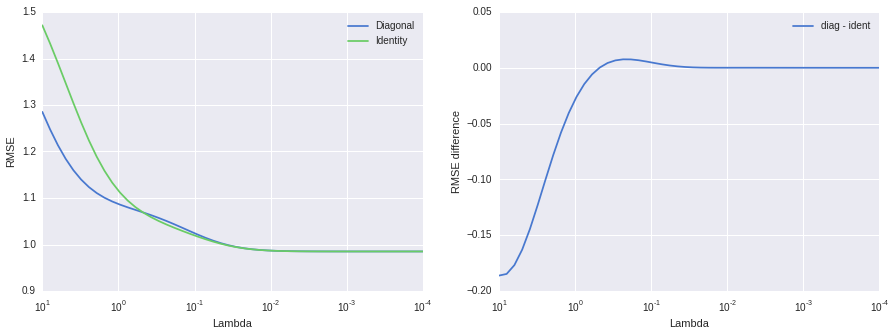

In [8]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.ylabel("RMSE")
plt.xlabel("Lambda")
plt.plot(lambdas, diag_mean)
plt.plot(lambdas, ident_mean)
plt.legend(['Diagonal', 'Identity'])
plt.xscale('log')
plt.gca().invert_xaxis()

plt.subplot(122)
plt.ylabel("RMSE difference")
plt.xlabel("Lambda")
plt.plot(lambdas, diff_mean)
plt.legend(['diag - ident'])
plt.xscale('log')
plt.gca().invert_xaxis()